In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import datetime
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
plt.style.use('fivethirtyeight')

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Chapter 6: A Simple Classification Problem

For the classification, once again, we'll use Scikit-Learn’s make_moons to generate a toy dataset with 100 data points and two features (x1 and x2). We will also add some Gaussian noise but, this time, we're adding **more noise** (0.8 instead of 0.3) to the dataset, thus making it harder for our model to classify the data point.

## Data Generation

In [2]:
X, y = make_moons(n_samples=100, noise=0.8, random_state=11)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

Your first task is to use Scikit-Leanr's `StandardScaler` to standardize our dataset's features:

### Answer

In [3]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [4]:
from matplotlib.colors import ListedColormap

def figure1(X_train, y_train, X_val, y_val, cm_bright=None):
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)#, edgecolors='k')
    ax[0].set_xlabel(r'$X_1$')
    ax[0].set_ylabel(r'$X_2$')
    ax[0].set_xlim([-2.3, 2.3])
    ax[0].set_ylim([-2.3, 2.3])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright)#, edgecolors='k')
    ax[1].set_xlabel(r'$X_1$')
    ax[1].set_ylabel(r'$X_2$')
    ax[1].set_xlim([-2.3, 2.3])
    ax[1].set_ylim([-2.3, 2.3])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()
    
    return fig

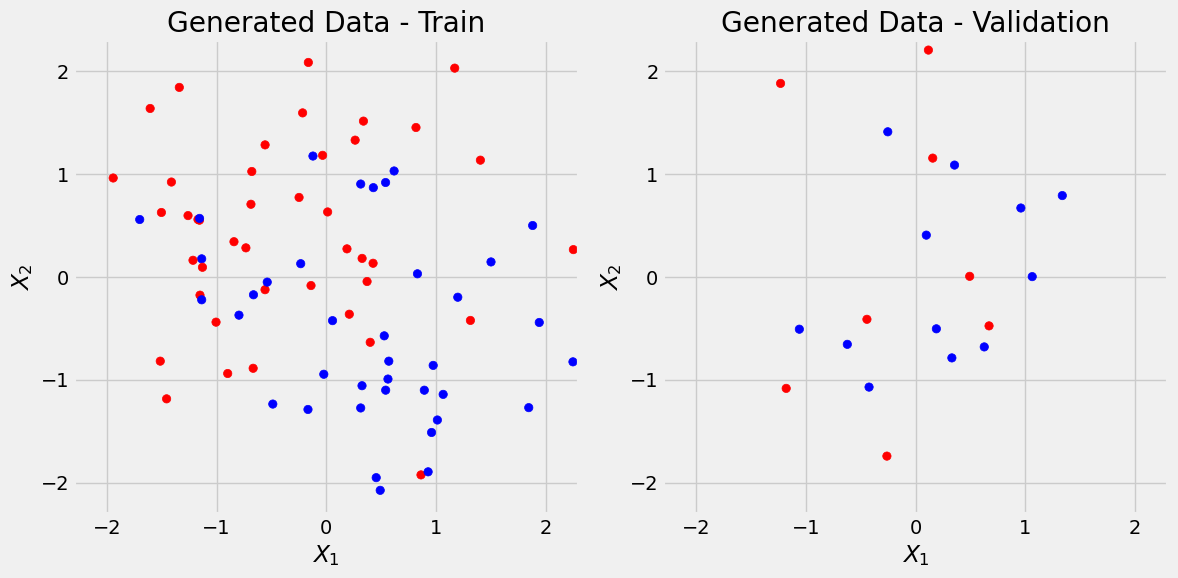

In [5]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

The preparation of data starts by **converting the data points** from Numpy arrays to PyTorch tensors and sending them to the available **device**:

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

Once again, the data preparation also includes creating datasets and data loaders for both training and validation sets. That's your task now - you're free to choose any mini-batch size you want (and we encourage you to play with different values), but we suggest you to start with 16:

Hint: you can use a simple `TensorDataset` for this task

### Answer

In [7]:
# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model Configuration

Your task is, once again, to define a **model**, an **optimizer**, and a **loss function** to tackle our **linear** regression with a **single input** and **single output**:

Hint: your model can either output **logits** or **probabilities** - whatever your choice is, make sure you're using the appropriate loss function for your model

### Answer 1

In [8]:
torch.manual_seed(42)

lr = 0.1

model = nn.Sequential(nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

### Answer 2

In [9]:
torch.manual_seed(42)

lr = 0.1

model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCELoss()

## Model Training

For the model training, we'll use our `StepByStep` class once again:

In [10]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step
    
    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

Your task is to create an instance of the `StepByStep` class using the model, loss, and optimizer created in the "Model Configuration", set the data loaders, train for 40 epochs, and plot the losses:

### Answer

OrderedDict([('0.weight', tensor([[ 0.7083, -0.9172]], device='cuda:0')), ('0.bias', tensor([-0.1143], device='cuda:0'))])


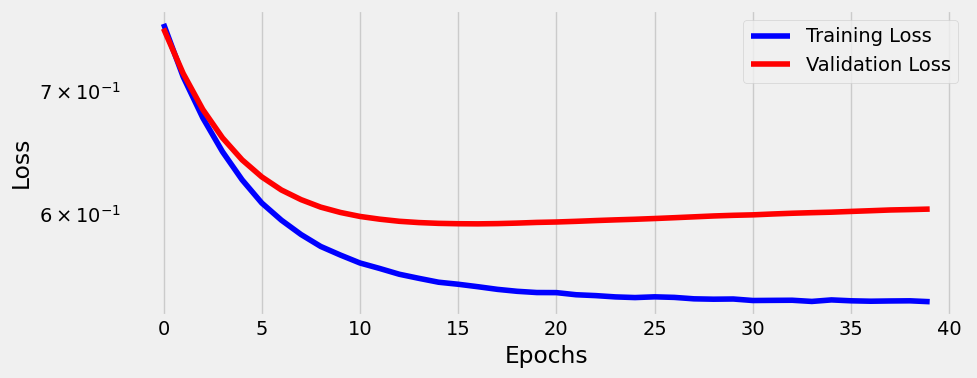

In [11]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs=40)

print(sbs.model.state_dict())
fig = sbs.plot_losses()

## Predictions

Now, your task is to **predict probabilities** for the first 20 data points in the validation set:
    
Hint: don't forget to set the model to the proper mode for making predictions

In [12]:
some_x, some_y = val_dataset[:20]

### Answer 1

In [13]:
# model = nn.Sequential(nn.Linear(2, 1))

model.eval()
logits = model(some_x.to(device))
probs = torch.sigmoid(logits)
probs

tensor([[0.5737],
        [0.5638],
        [0.6194],
        [0.6357],
        [0.6868],
        [0.6542],
        [0.6287],
        [0.5990],
        [0.6657],
        [0.6250],
        [0.6578],
        [0.6249],
        [0.6729],
        [0.5156],
        [0.5423],
        [0.5979],
        [0.6498],
        [0.5284],
        [0.6195],
        [0.6679]], device='cuda:0', grad_fn=<SigmoidBackward0>)

### Answer 2

In [14]:
# model = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())

model.eval()
probs = model(some_x.to(device))
probs

tensor([[0.2971],
        [0.2565],
        [0.4869],
        [0.5568],
        [0.7852],
        [0.6377],
        [0.5266],
        [0.4012],
        [0.6888],
        [0.5110],
        [0.6535],
        [0.5105],
        [0.7214],
        [0.0622],
        [0.1695],
        [0.3967],
        [0.6180],
        [0.1135],
        [0.4874],
        [0.6985]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [15]:
threshold = .5
confusion_matrix(some_y, (probs.cpu() >= threshold))

array([[4, 4],
       [5, 7]])

Congratulations! You successfully trained a PyTorch model for a classification task!